## 데이터 로드

In [84]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/aiffel-dj17/aiffel/ocr


## Recognition model

In [85]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


36개 클래스 필요

### 필요 모듈 import

In [86]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

/home/aiffel-dj17/aiffel/ocr/MJ/MJ_train


## Recognition model (2) Input Image
### input image 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


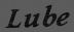

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


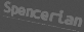

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


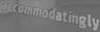

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


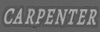

In [4]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현.
- dataset_path는 읽어들일 데이터셋의 경로. 
- label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

- 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영.   
- model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴.   
- _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공.

## Recognition model (3) Encode

In [6]:
class LabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

### 'HELLO' Encode, Decode 확인

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Recognition model (4) Build CRNN model

- Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들었다.

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## Recognition model (5) Train & Inference

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 23s 151ms/step - loss: 33.9499 - val_loss: 26.9908

Epoch 00001: val_loss improved from inf to 26.99085, saving model to /home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 9s 135ms/step - loss: 26.8419 - val_loss: 26.2928

Epoch 00002: val_loss improved from 26.99085 to 26.29283, saving model to /home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 9s 134ms/step - loss: 26.3044 - val_loss: 25.9576

Epoch 00003: val_loss improved from 26.29283 to 25.95760, saving model to /home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
63/63 [==============================] - 8s 129ms/step - loss: 25.9252 - val_loss: 26.7594

Epoch 00004: val_loss did not improve from 25.95760
Epoch 5/100
63/63 [==============================] - 8s 130ms/step - loss: 25.5168 - val_loss: 28.1034

Epoch 00005: val_loss did not improve from 25.95760
Epoch

63/63 [==============================] - 8s 129ms/step - loss: 3.0007 - val_loss: 3.0982

Epoch 00083: val_loss improved from 3.13285 to 3.09821, saving model to /home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5
Epoch 84/100
63/63 [==============================] - 8s 129ms/step - loss: 3.0716 - val_loss: 3.2026

Epoch 00084: val_loss did not improve from 3.09821
Epoch 85/100
63/63 [==============================] - 8s 133ms/step - loss: 2.9264 - val_loss: 3.1576

Epoch 00085: val_loss did not improve from 3.09821
Epoch 86/100
63/63 [==============================] - 8s 129ms/step - loss: 2.8898 - val_loss: 3.1717

Epoch 00086: val_loss did not improve from 3.09821
Epoch 87/100
63/63 [==============================] - 8s 128ms/step - loss: 2.9524 - val_loss: 3.0923

Epoch 00087: val_loss improved from 3.09821 to 3.09230, saving model to /home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5
Epoch 88/100
63/63 [==============================] - 8s 128ms/step - loss: 2.8176 - val_loss: 3.04

In [12]:
checkpoint_path

'/home/aiffel-dj17/aiffel/ocr/model_checkpoint.hdf5'

## Recognition model (5) Train & Inference

(1, 100, 32, 3)
Result: 	 SLINKING9999999999999999


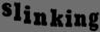

(1, 100, 32, 3)
Result: 	 ALEPPO99999999999999999


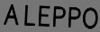

(1, 100, 32, 3)
Result: 	 RWANDA999999999999999999


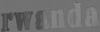

(1, 100, 32, 3)
Result: 	 NATHANS99999999999999999


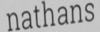

(1, 100, 32, 3)
Result: 	 KALLEO99999999999999999


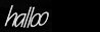

(1, 100, 32, 3)
Result: 	 HURLS9999999999999999999


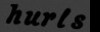

(1, 100, 32, 3)
Result: 	 DOWNSIZE9999999999999999


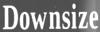

(1, 100, 32, 3)
Result: 	 ROBOTIC99999999999999999


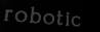

(1, 100, 32, 3)
Result: 	 SLOPPY99999999999999999


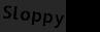

(1, 100, 32, 3)
Result: 	 HERMITE99999999999999999


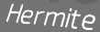

In [188]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        #print(img)
        #print(type(img))
        print(img.shape)
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## 프로젝트: End-to-End OCR
- 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용.
- inference한 후에 이를 시각화. 
- 단어의 영역을 자르기.

In [14]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import keras_ocr

SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/ocr/sample.jpg'

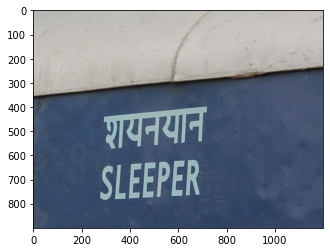

(900, 1200, 3)


In [15]:
image = keras_ocr.tools.read(SAMPLE_IMG_PATH)
plt.imshow(image)
plt.show()
print(image.shape)

In [102]:
image.shape

(900, 1200, 3)

In [30]:
image = keras_ocr.tools.read(SAMPLE_IMG_PATH)
pipeline = keras_ocr.pipeline.Pipeline()
prediction = pipeline.recognize([image])


Looking for /home/aiffel-dj17/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj17/.keras-ocr/crnn_kurapan.h5


In [62]:
ocr_result = prediction[0][1][1]

In [41]:
print(ocr_result[0][1][0])

[281.8156 450.021 ]


In [61]:
ocr_result

array([[269.26883, 643.607  ],
       [689.8353 , 613.4468 ],
       [700.2845 , 759.1539 ],
       [279.718  , 789.314  ]], dtype=float32)

In [44]:
type(ocr_result)

list

In [49]:
im = Image.open(SAMPLE_IMG_PATH)

In [69]:
ocr_result = prediction[0][1][1]
#문자면 무시하고 숫자면 진행하는 코드를 구상해야 될 것 같다.

In [70]:
ocr_result

array([[269.26883, 643.607  ],
       [689.8353 , 613.4468 ],
       [700.2845 , 759.1539 ],
       [279.718  , 789.314  ]], dtype=float32)

In [72]:
xy_l = []
for text_result in ocr_result:
    xy_l.append(tuple(text_result))
    
print(xy_l)
    

[(269.26883, 643.607), (689.8353, 613.4468), (700.2845, 759.1539), (279.718, 789.314)]


In [181]:
def Crop_IMG(xy_l):
    cropped_imgs = []
    draw = ImageDraw.Draw(im)
    draw.polygon(xy_l, outline='red')
    x_min = ocr_result[:,0].min() - 5
    x_max = ocr_result[:,0].max() + 5
    y_min = ocr_result[:,1].min() - 5
    y_max = ocr_result[:,1].max() + 5
    word_box = [x_min, y_min, x_max, y_max]
    cropped_imgs.append(im.crop(word_box))
    
    return cropped_imgs

In [182]:
cropped_imgs=Crop_IMG(xy_l)

In [183]:
im.show()

![Screenshot from 2021-05-06 02-30-27](https://user-images.githubusercontent.com/60597598/117217993-4e032880-ae3d-11eb-92d6-5a3a54ef78df.png)

In [184]:
cropped_imgs[0].show()

![Screenshot from 2021-05-06 07-36-23](https://user-images.githubusercontent.com/60597598/117218263-ca960700-ae3d-11eb-97d5-c7936a645a10.png)


In [185]:
def check_img_inference(model, imgs, index = 5):
    ad=imgs.transpose(1,0,2)
    imgs = imgs[tf.newaxis, :, :, :]
    print(imgs.shape)
    output = model_pred.predict(imgs)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    pil_image=Image.fromarray(ad)
    display(pil_image)

In [186]:
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img=pil_img.resize((100,32))
    pil_img=np.array(pil_img)
    pil_img=pil_img.transpose(1,0,2)
    
    check_img_inference(model, pil_img, index=10)
    

(1, 100, 32, 3)
Result: 	 SLEEPER9999999999999999


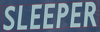

In [187]:
for _img in cropped_imgs:
    recognize_img(_img)

## 루브릭
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.  
- 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.  

2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.  
- 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.  

3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.  
- 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.  

## 마치며...
- 이번 노드는 난이도가 많이 높았던 것 같다. 함수를 직접 구현하는 것이 꽤 어려웠다. 일단 OCR 분야는 해커톤에서 쓰지 않을 예정이지만 나중에 드론으로 표지판이나 전화번호를 OCR을 해서 위치를 추정하는 기능을 해보고 싶다.일단 함수 구현할 때 많이 충돌한 에러는 Value_Error 이다. input shape 이 잘 맞지 않아서 newaxis와 resize, transpose 함수로 해결하였다.노드에서는 이 과정을 한꺼번에 한줄에 했는데 직접 할 땐 잘 안돼서 나눠서 했다. 그리고 crop 을 하기 위해 pillow와 keras-OCR에 대해서도 잘 알아야 했다. 이렇게 함수와 모델을 만들어서 하는 예제가 별로 없어서 github와 함수 설명을 잘 찾아봐야 했다. 먼저 keras-OCR의 pipeline.recognize() 함수를 쓸때는 꼭 소괄호 안에 대괄호를 넣어야 했다. 그리고 pipeline.recognize()로 return 되는 값도 행렬과 문자가 같이 나와서 잘 살펴봐야 했다. Pillow의 poligon을 할 때는 ImageDraw.Draw()로 먼저 정의한 후에 사용해야 했다.